# CHEE 807, Fall 2021
- Queen's University
- Instructor: Laurence Yang

## Previously,
- in the last lecture, we formulated optknock in class
- we obtained a solution that deleted two reactions

## In this notebook:
- we will add an integer cut to find alternative solutions

# 1. Import required modules and define helpful functions

In [7]:
from cobra.io import load_json_model
from cobra import Metabolite, Reaction, Model

## Define a function to re-load the model for an organism and adjust the default bounds

In [8]:
def reload_model(org='yeast'):
    # model = load_json_model('iML1515.json')

    if org=='yeast':
        print('Organism is S. cerevisiae')
        model = load_json_model('iMM904.json')
        rxn_bio = 'BIOMASS_SC5_notrace'
    else:
        print('Organism is E. coli')
        model = load_json_model('iAF1260.json')
        rxn_bio = 'BIOMASS_Ec_iAF1260_core_59p81M'

    for rxn in model.reactions:
        if rxn.upper_bound > 1000:
            rxn.upper_bound = 1000
        if rxn.lower_bound < -1000:
            rxn.lower_bound = -1000
            
    return model, rxn_bio

## Define a function to draw the production envelope

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def prod_env(model, varx, vary):
    
    model.optimize()
    mu_max = model.reactions.get_by_id(varx).x
    mu_max

    rows = []
    for muj in np.linspace(0, mu_max*0.999, 10):
        model.reactions.get_by_id(rxn_bio).lower_bound = muj
        model.reactions.get_by_id(rxn_bio).upper_bound = muj

        for rxn in model.reactions:
            rxn.objective_coefficient = 0.

        # Set objective to succinate maximization
        rxn_prod = model.reactions.get_by_id(vary)
        rxn_prod.objective_coefficient = 1.

        model.optimize('maximize')
        vmax = rxn_prod.x
        # minimize succinate production
        model.optimize('minimize')
        vmin = rxn_prod.x

        # STore solution
        rows.append({'mu':muj, 'vmax':vmax, 'vmin':vmin})

    df = pd.DataFrame(rows)
    plt.plot('mu', 'vmax', data=df, label='vmax')
    plt.plot('mu', 'vmin', data=df, label='vmin')
    plt.legend()
    plt.xlabel('Growth rate (1/h)')
    plt.ylabel('%s flux (mmol/gDW/h)'%vary)
    
    return df

# 2. Formulate OptKnock
- the objective is to maximize target chemical production
- set the required growth rate
- constrain the total number of knockouts
- also fix any binary variables to 1 if we don't want to remove that reaction

$$
\begin{align}
\max_{w,a,b,\sigma, y} \quad & v^\text{prod} \\
\text{subject to} \quad & Sv = 0 \\
& S^T w + b- a + \sigma  = c \\
& 0^T w+ u^T b - l^T a + 0^T \sigma = c^T v\\
& 0 \leq a \leq \mu^U y \\
& 0 \leq b \leq \eta^U y \\
& -M\cdot (1-y) \leq \sigma \leq M\cdot (1-y) \\
& l y \leq v \leq u y \\
& v^\text{biomass} \geq v^\text{biomass}_\text{min} \\
& \sum_J (1 - y_j) \leq K \\
 & y \in \{0,1\} \\
 & y_i = 1, \quad \forall i \in \text{DoNotDelete}
\end{align}
$$

In [46]:
### Test the primal
model, rxn_bio = reload_model()
print('Primal objective:', model.optimize())

### Test just the dual
optknock = Model('optknock')

all_vars = []
for met in model.metabolites:
    w = Reaction('w_%s'%met.id, lower_bound=-1000, upper_bound=1000)
    all_vars.append(w)
    
for rxn in model.reactions:
    v   = Reaction(rxn.id, lower_bound=rxn.lower_bound, upper_bound=rxn.upper_bound)
    v.objective_coefficient = rxn.objective_coefficient
        
    a   = Reaction('a_%s'%rxn.id, lower_bound=0, upper_bound=1000)
    b   = Reaction('b_%s'%rxn.id, lower_bound=0, upper_bound=1000)   
    y   = Reaction('y_%s'%rxn.id, lower_bound=0, upper_bound=1)
    y.variable_kind = 'integer'
    
    # This is the dual for v_j = 0 for j in KO
    sigma = Reaction('sigma_%s'%rxn.id, lower_bound=-1000, upper_bound=1000)
    
    all_vars.append(v)
    all_vars.append(a)
    all_vars.append(b)
    all_vars.append(y)
    all_vars.append(sigma)
    
optknock.add_reactions(all_vars)
    
all_constraints = []
for rxn in model.reactions:
    cons = Metabolite('dual_%s'%rxn.id)
    cons._bound = rxn.objective_coefficient
    cons._constraint_sense = 'E'        
    
    v = optknock.reactions.get_by_id(rxn.id)
    for met,stoich in rxn.metabolites.items():        
        w = optknock.reactions.get_by_id('w_%s'%met.id)
        w.add_metabolites({cons:stoich})
        
        #**********************************        
        met2 = Metabolite(met.id)
        met2._bound = met._bound
        met2._constraint_sense = met._constraint_sense
        v.add_metabolites({met2:stoich})
        #**********************************
    
    # S*w + b - a + sigma = c
    a = optknock.reactions.get_by_id('a_%s'%rxn.id)
    b = optknock.reactions.get_by_id('b_%s'%rxn.id)
    sigma = optknock.reactions.get_by_id('sigma_%s'%rxn.id)
    b.add_metabolites({cons:1})
    a.add_metabolites({cons:-1})
    sigma.add_metabolites({cons:1})
    
    all_constraints.append(cons)
    
    #------------------------------------------------
    # If vj = 0 constraint active, then the original bounds'
    # dual variables, a and b must be zero
    # a <= muU*y   : a - muU*y <= 0
    # b <= etaU*y  : b - etaU*y <= 0    
    BIGM = 1e3
    
    y = optknock.reactions.get_by_id('y_%s'%rxn.id)
    
    cons = Metabolite('mu_U_%s'%rxn.id)
    cons._constraint_sense = 'L'
    cons._bound = 0
    a.add_metabolites({cons:1})
    y.add_metabolites({cons:-BIGM})
    all_constraints.append(cons)
    
    cons = Metabolite('eta_U_%s'%rxn.id)
    cons._constraint_sense = 'L'
    cons._bound = 0
    b.add_metabolites({cons:1})
    y.add_metabolites({cons:-BIGM})
    all_constraints.append(cons)
    #------------------------------------------------
    # -M*(1-y) <= sigma <= M*(1-y)
    # Lower bound: sigma - M*y >= -M
    # Upper bound: sigma + M*y <= M

    cons = Metabolite('sigma_L_%s'%rxn.id)
    cons._constraint_sense = 'G'
    cons._bound = -BIGM
    sigma.add_metabolites({cons:1})
    y.add_metabolites({cons:-1*BIGM})
    
    cons = Metabolite('sigma_U_%s'%rxn.id)
    cons._constraint_sense = 'L'
    cons._bound = BIGM
    sigma.add_metabolites({cons:1})
    y.add_metabolites({cons:BIGM})
    
    all_constraints.append(cons)
    #------------------------------------------------
    
### Instead of setting dual or primal objectives, now set primal obj = dual obj
# 0'w + u'b - l'a + 0'*sigma - c'v  = 0

cons = Metabolite('duality_gap')
cons._constraint_sense = 'E'
cons._bound = 0

for rxn in model.reactions:
    b = optknock.reactions.get_by_id('b_%s'%rxn.id)
    a = optknock.reactions.get_by_id('a_%s'%rxn.id)
    v   = optknock.reactions.get_by_id(rxn.id)
    b.add_metabolites({cons:rxn.upper_bound})
    a.add_metabolites({cons:-1*rxn.lower_bound})
    v.add_metabolites({cons:-1*rxn.objective_coefficient})
    ### These should just be 0*w = 0
    for met,stoich in rxn.metabolites.items():
        w.add_metabolites({cons:met._bound})

all_constraints.append(cons)


for rxn in model.reactions:
    v = optknock.reactions.get_by_id(rxn.id)
    y = optknock.reactions.get_by_id('y_%s'%rxn.id)
    
    ### v >= l*y  :  v - l*y >= 0
    cons = Metabolite('lb_y_%s'%rxn.id)
    cons._constraint_sense = 'G'
    v.add_metabolites({cons:1.})
    y.add_metabolites({cons:-1*rxn.lower_bound})    
    all_constraints.append(cons)
    
    ### v <= u*y  : v - u*y <= 0     
    cons = Metabolite('ub_y_%s'%rxn.id)
    cons._constraint_sense = 'L'
    v.add_metabolites({cons:1.})
    y.add_metabolites({cons:-1*rxn.upper_bound})    
    all_constraints.append(cons)
       
    
#-------------------------
# sum( 1 - y) <= K
# N - sum(y) <= K
# sum(y) >= N - K

ys = optknock.reactions.query('^y_')
N = len(ys)
print('Total of %d y variables'%N)
#-------------------------
K = 2
print('Total of %d allowed knockouts'%K)
#-------------------------
cons = Metabolite('max_KO')
cons._constraint_sense = 'G'
cons._bound = N-K

for y in optknock.reactions.query('^y_'):
    y.add_metabolites({cons:1})
    
all_constraints.append(cons)

#-----------------------------
### ADD IN ALL THE CONSTRAINTS
optknock.add_metabolites(all_constraints)

### Objective coefficients
for x in optknock.reactions:
    x.objective_coefficient = 0.

#-----------------------------------------------------
### Some Reactions should not be allowed to be deleted
# ATPM: ATP maintenance
optknock.reactions.y_ATPM.lower_bound = 1
# Growth rate
optknock.reactions.get_by_id('y_%s'%rxn_bio).lower_bound = 1
# The exchange reactions
for rxn in optknock.reactions.query('^EX_'):
    y = optknock.reactions.get_by_id('y_%s'%rxn.id)
    y.lower_bound = 1
    
# Any reaction that is not associated with a gene
for rxn in model.reactions:
    if len(rxn.genes)==0:
        y = optknock.reactions.get_by_id('y_%s'%rxn.id)
        y.lower_bound = 1

#-----------------------------------------------------
### Maximize the target
rxn_target = 'EX_succ_e'
optknock.reactions.get_by_id(rxn_target).objective_coefficient = 1.

#-----------------------------------------------------
### Force minimum required growth rate
GROWTH_MIN = 0.05
optknock.reactions.get_by_id(rxn_bio).lower_bound = GROWTH_MIN


#-----------------------------------------------------
# SOLVE
%time print('OptKnock objective:', optknock.optimize('maximize', solver='gurobi', integer_feasibility=1e-9, threads=11))


#-----------------------------------------------------
# Interpret the solution
y_new = {y:y.x for y in optknock.reactions.query('^y_')}
print('Total Knockouts: %d'%(sum(np.array(list(y_new.values()))==0)))
print('Knockouts:')
for y,yv in y_new.items():
    if yv < 0.5:
        rxn = optknock.reactions.get_by_id(y.id.replace('y_',''))
        print('%s=%d\t%s'%(y.id, yv, rxn.reaction))
    
print('Growth rate:', optknock.reactions.get_by_id(rxn_bio).x)
print('Production rate:', optknock.reactions.get_by_id(rxn_target).x)


# ys = np.array([y.x for y in optknock.reactions.query('^y_')])
# print('Target chemical: %s'%rxn_target)
# print('Total Knockouts: %d'%(sum(1-ys)))


# print('Growth rate:', optknock.reactions.get_by_id(rxn_bio).x)
# print('Production rate:', optknock.reactions.get_by_id(rxn_target).x)

Organism is S. cerevisiae
Primal objective: <Solution 0.29 at 0x7faabdab3950>
Total of 1577 y variables
Total of 2 allowed knockouts
OptKnock objective: <Solution 9.07 at 0x7faa887caf50>
CPU times: user 1h 15min 55s, sys: 51.7 s, total: 1h 16min 47s
Wall time: 7min 41s
Total Knockouts: 2
Knockouts:
y_ME2m=0	mal__L_m + nadp_m --> co2_m + lb_y_ME2m + nadph_m + pyr_m + ub_y_ME2m
y_PYRDC=0	h_c + pyr_c --> acald_c + co2_c + lb_y_PYRDC + ub_y_PYRDC
Growth rate: 0.1711567374050771
Production rate: 9.069339712918804


## Save the current solution

In [47]:
y_prev = {y:y.x for y in optknock.reactions.query('^y_')}

# 3. Production envelopes

## Wild-type

Organism is S. cerevisiae


,mu,vmax,vmin
0,0.000000,13.982833,0.0
1,0.031953,13.546867,0.0
2,0.063906,13.110901,0.0
3,0.095859,12.674935,0.0
4,0.127812,12.223116,0.0
5,0.159765,11.766700,0.0
6,0.191719,9.526091,0.0
7,0.223672,6.542344,0.0
8,0.255625,3.323429,0.0
9,0.287578,0.029673,0.0


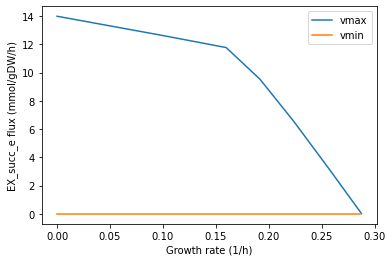

In [48]:
model,rxn_bio = reload_model()
prod_env(model, rxn_bio, rxn_target)

Organism is S. cerevisiae


,mu,vmax,vmin
0,0.000000,13.927602,0.000000
1,0.018998,13.663115,0.000000
2,0.037997,13.398629,0.000000
3,0.056995,13.134143,0.000000
4,0.075994,12.869656,0.000000
5,0.094992,12.605170,0.020651
6,0.113990,12.340684,1.524781
7,0.132989,12.076197,3.028911
8,0.151987,11.811711,4.533041
9,0.170986,9.328276,8.885960


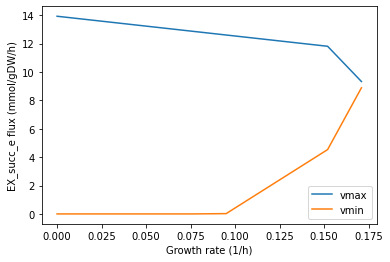

In [49]:
model,rxn_bio = reload_model()
model.reactions.PYRDC.upper_bound = 0
model.reactions.ME2m.upper_bound = 0
prod_env(model, rxn_bio, rxn_target)

# 4. Add an integer cut, forcing a different solution

$$
\sum_{j\in y_p=0} y_j + \sum_{j\in y_p=1} (1-y_j) \geq 1
$$

$$
\sum_{j\in y_p=0} y_j - \sum_{j\in y_p=1} y_j \geq 1 - N_1
$$

- a Metabolite is a linear constraint
- a Reaction is a variable

In [50]:
cut = Metabolite('cut_0')
cut._constraint_sense = 'G'

N1 = sum(y_prev.values())
cut._bound = 1 - N1

for y,yp in y_prev.items():
    if yp>0.5:
        y.add_metabolites({cut:-1})
    else:
        y.add_metabolites({cut:1})

optknock.add_metabolites(cut)

In [53]:
#-----------------------------------------------------
# SOLVE
print('OptKnock objective:', optknock.optimize('maximize', solver='gurobi', integer_feasibility=1e-9, threads=11))

#-----------------------------------------------------
# Interpret the solution
y_new = {y:y.x for y in optknock.reactions.query('^y_')}
print('Total Knockouts: %d'%(sum(np.array(list(y_new.values()))==0)))
print('Knockouts:')
for y,yv in y_new.items():
    if yv < 0.5:
        rxn = optknock.reactions.get_by_id(y.id.replace('y_',''))
        print('%s=%d\t%s'%(y.id, yv, rxn.reaction))
    
print('Growth rate:', optknock.reactions.get_by_id(rxn_bio).x)
print('Production rate:', optknock.reactions.get_by_id(rxn_target).x)

OptKnock objective: <Solution 8.66 at 0x7faa83514fd0>
Total Knockouts: 2
Knockouts:
y_PIt2m=0	h_c + pi_c <=> h_m + lb_y_PIt2m + pi_m + ub_y_PIt2m
y_PYRDC=0	h_c + pyr_c --> acald_c + co2_c + lb_y_PYRDC + ub_y_PYRDC
Growth rate: 0.17245549486272713
Production rate: 8.658983876207571


In [54]:
y_opt2 = {y:y.x for y in optknock.reactions.query('^y_')}

# Interpret

|Solution | Growth rate | Max production | # of Knockouts | Knockout reactions  |
|---|---|---|---|---|
|  1      | 0.1711567374050771 | 9.069339712918804 |  2  | ME2m, PYRDC |
|  2      | 0.17245549486272713 | 8.658983876207571 |  2  | PIt2m, PYRDC |

## Worth noting:
- the set of knocked out reactions for Solution 2 differs from that of solution 1 (PIt2m intead of ME2m)
- the second solution has lower max production rate than the first: suboptimal compared to the first
- thus, no other two-knock out solution exists that reaches 9.07 mmol/gDW/h

### New mutant

Organism is S. cerevisiae
Knocked out reaction PIt2m
Knocked out reaction PYRDC


,mu,vmax,vmin
0,0.000000,13.927602,0.000000
1,0.019143,13.661108,0.000000
2,0.038285,13.394615,0.000000
3,0.057428,13.128122,0.000000
4,0.076570,12.861629,0.000000
5,0.095713,12.595135,0.000000
6,0.114855,12.328642,0.769307
7,0.133998,12.062149,3.119747
8,0.153140,11.795655,5.479572
9,0.172283,8.796321,8.626035


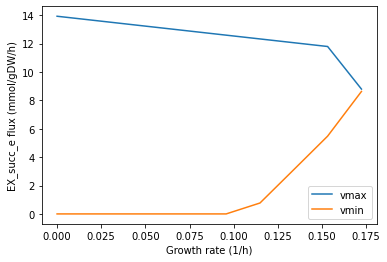

In [59]:
model,rxn_bio = reload_model()

for yj, valj in y_opt2.items():
    if valj<0.5:
        rxn_id = yj.id.replace('y_','')
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.upper_bound = 0
        rxn.lower_bound = 0
        print('Knocked out reaction %s'%rxn.id)

prod_env(model, rxn_bio, rxn_target)

# 5. Add another cut, this time excluding Solution 2

In [69]:
cut = Metabolite('cut_1')
cut._constraint_sense = 'G'

N1 = sum(y_opt2.values())
cut._bound = 1 - N1

for y,yp in y_opt2.items():
    if yp>0.5:
        y.add_metabolites({cut:-1})
    else:
        y.add_metabolites({cut:1})

optknock.add_metabolites(cut)

In [70]:
#-----------------------------------------------------
# SOLVE
%time print('OptKnock objective:', optknock.optimize('maximize', solver='gurobi', integer_feasibility=1e-9, threads=11))

#-----------------------------------------------------
# Interpret the solution
y_new = {y:y.x for y in optknock.reactions.query('^y_')}
print('Total Knockouts: %d'%(sum(np.array(list(y_new.values()))==0)))
print('Knockouts:')
for y,yv in y_new.items():
    if yv < 0.5:
        rxn = optknock.reactions.get_by_id(y.id.replace('y_',''))
        print('%s=%d\t%s'%(y.id, yv, rxn.reaction))
    
print('Growth rate:', optknock.reactions.get_by_id(rxn_bio).x)
print('Production rate:', optknock.reactions.get_by_id(rxn_target).x)

OptKnock objective: <Solution 7.91 at 0x7faa880da650>
CPU times: user 58min 21s, sys: 54.9 s, total: 59min 16s
Wall time: 6min 10s
Total Knockouts: 2
Knockouts:
y_MDH=0	mal__L_c + nad_c <=> h_c + lb_y_MDH + nadh_c + oaa_c + ub_y_MDH
y_PYRDC=0	h_c + pyr_c --> acald_c + co2_c + lb_y_PYRDC + ub_y_PYRDC
Growth rate: 0.11436874729781656
Production rate: 7.905300135717994


In [71]:
y_opt3 = {y:y.x for y in optknock.reactions.query('^y_')}

Organism is S. cerevisiae
Knocked out reaction MDH
Knocked out reaction PYRDC


,mu,vmax,vmin
0,0.000000,13.550000,0.000000
1,0.012695,13.365961,0.000000
2,0.025390,13.181921,0.000000
3,0.038085,12.997882,0.000000
4,0.050780,12.813842,0.000000
5,0.063475,12.629803,0.000000
6,0.076170,12.445763,0.000000
7,0.088865,12.261724,0.000000
8,0.101559,11.429747,0.000000
9,0.114254,7.940728,7.772304


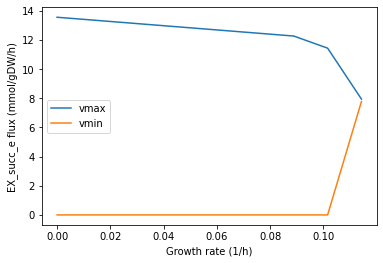

In [72]:
model,rxn_bio = reload_model()

for yj, valj in y_opt3.items():
    if valj<0.5:
        rxn_id = yj.id.replace('y_','')
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.upper_bound = 0
        rxn.lower_bound = 0
        print('Knocked out reaction %s'%rxn.id)

prod_env(model, rxn_bio, rxn_target)

## Summary

|Solution | Growth rate | Max production | # of Knockouts | Knockout reactions  |
|---|---|---|---|---|
|  1      | 0.1711567374050771 | 9.069339712918804 |  2  | ME2m, PYRDC |
|  2      | 0.17245549486272713 | 8.658983876207571 |  2  | PIt2m, PYRDC |
| 3       | 0.11436874729781656 |  7.905300135717994 | 2 | MDH, PYRDC |